In [1]:
import sys
sys.path.append('../../../')


import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as md
from tqdm import tqdm
from scipy import stats
import time

import torch as tc

from BayesNewton import bayesnewton
import objax

from sklearn.linear_model import LinearRegression

from rcgp.rcgp import TemporalRCGP

In [2]:
data = pd.read_csv("../../../data/kaggle_HFT_index_futures.csv")
obs = data["last_price"].to_numpy()
obs_grid = np.arange(0, len(obs)) * 0.001 * 500

max_idx = 46800
center_idx = 2868

mean = obs[:max_idx].mean()
obs_std = obs[:max_idx].std()
obs = (obs[:max_idx] - mean)/obs_std
obs_grid = obs_grid[:max_idx]

print("Dataset Size : {}".format(len(obs)))

Dataset Size : 46800


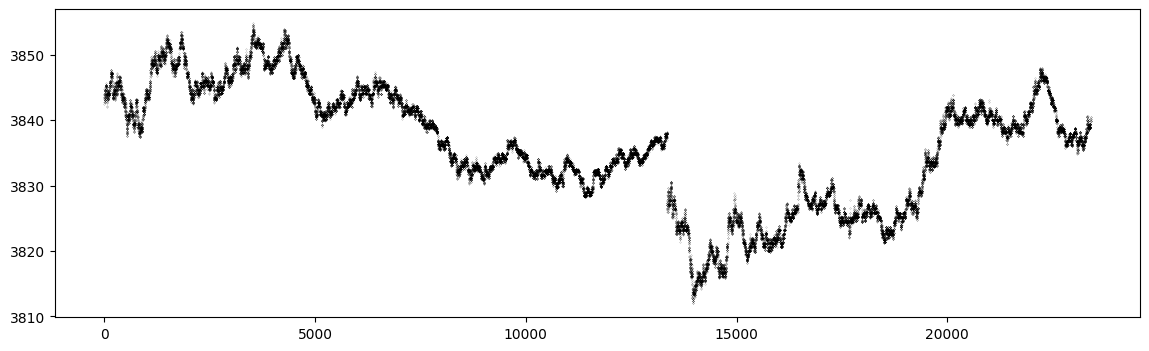

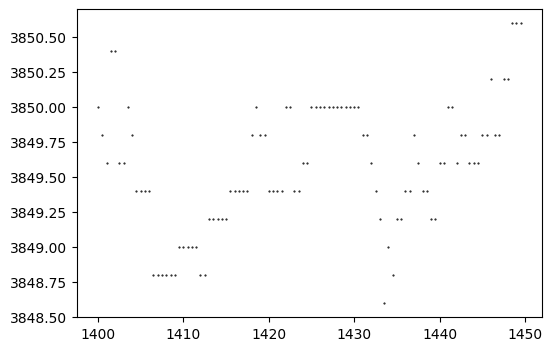

In [3]:
plt.figure(figsize=(14,4))
#plt.plot(obs_grid[outliers_idx], obs[outliers_idx] * obs_std + mean, '.',  color='red', markersize=5.)
plt.plot(obs_grid, obs * obs_std + mean, '.', color='black', markersize=0.2)

plt.figure(figsize=(6,4))
#plt.plot(obs_grid[outliers_idx], obs[outliers_idx] * obs_std + mean, '.',  color='red', markersize=10.)
plt.plot(obs_grid[2800:2900], obs[2800:2900] * obs_std + mean, '.', color='black', markersize=1)

In [4]:
def neg_log_likelihood(Y, pred, var):
    z = (Y - pred) / np.sqrt(var)
    print("Student-t", np.nanmean(stats.t.logpdf(z, df=1)))
    print("Normal", np.nanmean(stats.norm.logpdf(z)))

def rmse(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())

def mae(predictions, targets):
    return np.abs(predictions - targets).mean()

def nlpd(y_true, mu_pred, sigma_pred):

    # Ensure inputs are numpy arrays
    y_true = np.array(y_true)
    mu_pred = np.array(mu_pred)
    sigma_pred = np.array(sigma_pred)
    
    # Avoid division by zero or invalid log by adding a small epsilon to sigma
    epsilon = 1e-8
    sigma_pred = np.maximum(sigma_pred, epsilon)
    
    # Compute log predictive density for Gaussian
    log_pdf = -0.5 * np.log(2 * np.pi * sigma_pred**2) - ((y_true - mu_pred)**2 / (2 * sigma_pred**2))
    
    # Compute and return the NLPD
    nlpd = -np.mean(log_pdf)
    return nlpd

In [5]:
def stgp(obs_grid, obs, return_output=True):

    with tc.no_grad():
        rtgp = TemporalRCGP(ts=tc.from_numpy(obs_grid).reshape(-1,1), Ys=tc.from_numpy(obs).reshape(-1,1), p=1)

        rtgp.deactivate_robustness()

        rtgp.temporal_lengthscale = 6.
        rtgp.temporal_magnitude = 6.
        rtgp.var_y = 0.14**2

        t1 = time.time()
        (preds_smooth, stds_smooth, eff), (preds_filt, covs_filt, R, Ws_norm), (ms, Ps) = rtgp.forward(smoothing=True) 
        t2 = time.time()

        if return_output:
            print("Prediction time : ", t2 - t1)
            return preds_smooth.numpy(), stds_smooth.numpy()

        else:
            return t2 - t1

In [6]:
def rtgp(obs_grid, obs, return_output=True):

    with tc.no_grad():
        rtgp = TemporalRCGP(ts=tc.from_numpy(obs_grid).reshape(-1,1), Ys=tc.from_numpy(obs).reshape(-1,1), p=1)

        rtgp.activate_robustness(func='m_pred')
        rtgp.adaptive_c()
        rtgp.temporal_lengthscale = 6.5
        rtgp.temporal_magnitude = 1.
        rtgp.var_y = 0.3**2

        t1 = time.time()
        (preds_smooth, stds_smooth, eff), (preds_filt, covs_filt, R, Ws_norm), (ms, Ps) = rtgp.forward(smoothing=True) 
        t2 = time.time()

        if return_output:
            print("Prediction time : ", t2 - t1)
            return preds_smooth.numpy(), stds_smooth.numpy()

        else:
            return t2 - t1

In [7]:
def bayes_newton_EP(obs_grid, obs, return_output=True):
    #These parameters are optimized (i.e. below are starting values only)
    var_f = 1.  # GP variance
    len_f = 0.8  # GP lengthscale
    var_y = 0.8  # observation noise

    kern = bayesnewton.kernels.Matern52(variance=var_f, lengthscale=len_f)
    gauss_lik = bayesnewton.likelihoods.Gaussian(variance=var_y)
    lik = bayesnewton.likelihoods.StudentsT(df=6)
    model = bayesnewton.models.MarkovExpectationPropagationGP(kernel=kern, likelihood=lik, X=obs_grid.reshape(-1,1), Y=obs.reshape(-1,1))
    
    lr_adam = 0.1
    lr_newton = 1.0
    iters = 100
    opt_hypers = objax.optimizer.Adam(model.vars())
    energy = objax.GradValues(model.energy, model.vars())


    @objax.Function.with_vars(model.vars() + opt_hypers.vars())

    def train_op():
        model.inference(lr=lr_newton)  # perform inference and update variational params
        dE, E = energy()  # compute energy and its gradients w.r.t. hypers
        opt_hypers(lr_adam, dE)
        return E
    
    train_op = objax.Jit(train_op)

    t0 = time.time()
    for i in range(1, iters + 1):
        loss = train_op()
        #print("iter %2d, energy: %1.4f" % (i, loss[0]))
    t1 = time.time()
    if return_output:print("optimisation time: %2.2f secs" % (t1 - t0))

    t1 = time.time()
    posterior_mean, posterior_var = model.predict_y(X=obs_grid.reshape(-1,1))
    t2 = time.time()

    if return_output: print("Negative Log Predictive Density: ")
    if return_output: print(model.negative_log_predictive_density(X=obs_grid.reshape(-1,1), Y=obs.reshape(-1,1)))


    if return_output: print("Prediction time (s) : ", t2 - t1)
    if return_output:print("Lengthscale : ", model.kernel.lengthscale)
    if return_output:print("Kernel Variance : ", model.kernel.variance)
    #print("Likelihood Variance : ", model.likelihood.variance)

    if return_output:
        return np.array(posterior_mean), np.sqrt(np.array(posterior_var)), model
    else:
        return t2 - t1

In [8]:
def bayes_newton_variational(obs_grid, obs, return_output=True):
    #These parameters are optimized (i.e. below are starting values only)
    var_f = 1.  # GP variance
    len_f = 0.8  # GP lengthscale
    var_y = 0.8  # observation noise

    kern = bayesnewton.kernels.Matern52(variance=var_f, lengthscale=len_f)
    lik = bayesnewton.likelihoods.StudentsT(df=6)
    model = bayesnewton.models.MarkovVariationalGP(kernel=kern, likelihood=lik, X=obs_grid.reshape(-1,1), Y=obs.reshape(-1,1))
    
    lr_adam = 0.1
    lr_newton = 1.0
    iters = 100
    opt_hypers = objax.optimizer.Adam(model.vars())
    energy = objax.GradValues(model.energy, model.vars())


    @objax.Function.with_vars(model.vars() + opt_hypers.vars())

    def train_op():
        model.inference(lr=lr_newton)  # perform inference and update variational params
        dE, E = energy()  # compute energy and its gradients w.r.t. hypers
        opt_hypers(lr_adam, dE)
        return E
    
    train_op = objax.Jit(train_op)

    t0 = time.time()
    for i in range(1, iters + 1):
        loss = train_op()
        #print("iter %2d, energy: %1.4f" % (i, loss[0]))
    t1 = time.time()
    if return_output: print("optimisation time: %2.2f secs" % (t1 - t0))

    t1 = time.time()
    posterior_mean, posterior_var = model.predict_y(X=obs_grid.reshape(-1,1))
    t2 = time.time()

    if return_output:

        print("Negative Log Predictive Density: ")
        print(model.negative_log_predictive_density(X=obs_grid.reshape(-1,1), Y=obs.reshape(-1,1)))


        print("Prediction time (s) : ", t2 - t1)
        print("Lengthscale : ", model.kernel.lengthscale)
        print("Kernel Variance : ", model.kernel.variance)
        #print("Likelihood Variance : ", model.likelihood.variance)

        return np.array(posterior_mean), np.sqrt(np.array(posterior_var)), model
    else:
        return t2 - t1

In [9]:
def bayes_newton_laplace(obs_grid, obs, return_output=True):
    #These parameters are optimized (i.e. below are starting values only)
    var_f = 1.  # GP variance
    len_f = 0.8  # GP lengthscale
    var_y = 1.  # observation noise

    kern = bayesnewton.kernels.Matern52(variance=var_f, lengthscale=len_f)
    lik = bayesnewton.likelihoods.StudentsT(df=4)
    model = bayesnewton.models.MarkovLaplaceGP(kernel=kern, likelihood=lik, X=obs_grid.reshape(-1,1), Y=obs.reshape(-1,1))
    
    lr_adam = 0.1
    lr_newton = 0.8
    iters = 100
    opt_hypers = objax.optimizer.Adam(model.vars())
    energy = objax.GradValues(model.energy, model.vars())


    @objax.Function.with_vars(model.vars() + opt_hypers.vars())

    def train_op():
        model.inference(lr=lr_newton)  # perform inference and update variational params
        dE, E = energy()  # compute energy and its gradients w.r.t. hypers
        opt_hypers(lr_adam, dE)
        return E
    
    train_op = objax.Jit(train_op)

    t0 = time.time()
    for i in range(1, iters + 1):
        loss = train_op()
        #print("iter %2d, energy: %1.4f" % (i, loss[0]))
    t1 = time.time()
    if return_output: 
        print("optimisation time: %2.2f secs" % (t1 - t0))

    t1 = time.time()
    posterior_mean, posterior_var = model.predict_y(X=obs_grid.reshape(-1,1))
    t2 = time.time()

    if return_output:
        print("Negative Log Predictive Density: ")
        print(model.negative_log_predictive_density(X=obs_grid.reshape(-1,1), Y=obs.reshape(-1,1)))


        print("Prediction time (s) : ", t2 - t1)
        print("Lengthscale : ", model.kernel.lengthscale)
        print("Kernel Variance : ", model.kernel.variance)
        #print("Likelihood Variance : ", model.likelihood.variance)

        return np.array(posterior_mean), np.sqrt(np.array(posterior_var)), model

    else:
        return t2 - t1

In [10]:
def get_onestep_speed(method):
    n_pts = [5, 10, 100, 500, 1000, 2000, 2500, 4000, 5000, 7500, 10000, 15000, 20000, 25000, 30000, 35000, 40000, len(obs)]
    ts = []
    i = 0 #location in dataset
    for n in n_pts:
        ts.append(method(obs_grid[int(i * n):int((i+1) * n)], obs[int(i * n):int((i+1) * n)], return_output=False))
        
    return np.array(n_pts), np.array(ts)

In [11]:
#Uncomment if necessary only. Code to get execution time.

comp_times = []

for i in range(5):
    print("First...")
    n_pts, rtgp_one_step_times = get_onestep_speed(rtgp);
    print("Second...")
    _, gp_one_step_times = get_onestep_speed(stgp);
    print("Third...")
    _, mep_one_step_times = get_onestep_speed(bayes_newton_EP);
    print("Fourth...")
    _, mvi_one_step_times = get_onestep_speed(bayes_newton_variational);
    print("Fifth...")
    _, mlgp_one_step_times = get_onestep_speed(bayes_newton_laplace);

    comp_times.append([n_pts.flatten(), rtgp_one_step_times, gp_one_step_times, mep_one_step_times, mvi_one_step_times, mlgp_one_step_times])

"""
pd.DataFrame({"n_data_pts" : n_pts.flatten(),
              "RTGP": rtgp_one_step_times,
              "MEP" : mep_one_step_times,
              "MVI" : mvi_one_step_times,
              "MLGP" : mlgp_one_step_times,
              "STGP" : gp_one_step_times}).to_csv("./comp-time-HFT.csv")"""

First...
Second...
Third...
Fourth...
Fifth...
First...
Second...
Third...
Fourth...
Fifth...
First...
Second...
Third...
Fourth...
Fifth...
First...
Second...
Third...
Fourth...
Fifth...
First...
Second...
Third...
Fourth...
Fifth...


'\npd.DataFrame({"n_data_pts" : n_pts.flatten(),\n              "RTGP": rtgp_one_step_times,\n              "MEP" : mep_one_step_times,\n              "MVI" : mvi_one_step_times,\n              "MLGP" : mlgp_one_step_times,\n              "STGP" : gp_one_step_times}).to_csv("./comp-time-HFT.csv")'

In [18]:
np.save('comp-times.npy', np.array(comp_times), allow_pickle=True)

In [20]:
comp_times=np.load('comp-times.npy', allow_pickle=True)

In [50]:
comp_times[:, 1, :].shape

(5, 18)

In [60]:
for i, name in enumerate(['ST-RCGP', 'STGP', 'MEP', 'MVI', 'MLa']):
    print(i+1,name)
    arr = comp_times[:4, i+1, :]
    print("Total (s) : ", arr.mean(axis=0)[-1], arr.std(axis=0)[-1])

    slope = []
    n_pts = comp_times[0, 0, :].reshape(-1,1)
    for j in range(4):
        data = arr[j, :].reshape(-1,1)
        lm = LinearRegression()
        lm.fit(n_pts, data)
        slope.append(lm.coef_[0] * 1000)
    
    print("1-Step (ms) : ", np.mean(slope), np.std(slope))

1 ST-RCGP
Total (s) :  9.360330879688263 0.422743328209273
1-Step (ms) :  0.19902524999180396 0.017334830125992733
2 STGP
Total (s) :  7.976068556308746 0.7064320452566
1-Step (ms) :  0.1655211085610646 0.007677839247665911
3 MEP
Total (s) :  29.095697820186615 0.44841390174531814
1-Step (ms) :  0.595325165427548 0.013068882199379695
4 MVI
Total (s) :  28.257311165332794 0.6179961714670966
1-Step (ms) :  0.6082252574501515 0.014213357169383406
5 MLa
Total (s) :  29.201807260513306 1.9628028724482267
1-Step (ms) :  0.6155404194107187 0.030287060462741214


In [64]:
"""df_times=pd.read_csv("./comp-time-HFT.csv", usecols=["n_data_pts", "STGP", "RTGP", "MEP", "MVI", "MLGP"])

for col in df_times.columns[1:]:
    n_pts = df_times["n_data_pts"].to_numpy().reshape(-1,1)
    data = df_times[col].to_numpy().reshape(-1,1)
    lm = LinearRegression()
    lm.fit(n_pts, data)
    
    print("{} : Intercept, Slope, Estimate (ms) : ".format(col), lm.intercept_, lm.coef_, lm.coef_[0] * 1000)"""

'df_times=pd.read_csv("./comp-time-HFT.csv", usecols=["n_data_pts", "STGP", "RTGP", "MEP", "MVI", "MLGP"])\n\nfor col in df_times.columns[1:]:\n    n_pts = df_times["n_data_pts"].to_numpy().reshape(-1,1)\n    data = df_times[col].to_numpy().reshape(-1,1)\n    lm = LinearRegression()\n    lm.fit(n_pts, data)\n    \n    print("{} : Intercept, Slope, Estimate (ms) : ".format(col), lm.intercept_, lm.coef_, lm.coef_[0] * 1000)'

In [65]:
"""df_times.set_index("n_data_pts").plot(linewidth=2,
                                    style='.-',
                                    markersize=12,
                                    figsize=(10,6),
                                    fontsize=16)
plt.xlabel("# Data Points", fontsize=18)  # X-axis label
plt.ylabel("Execution Time (s)", fontsize=18)  # Y-axis label
plt.xlim(df_times["n_data_pts"].iloc[0]-100, df_times["n_data_pts"].iloc[-1]+100)
#plt.savefig("./comp-time-HFT.pdf", format='pdf', bbox_inches='tight')"""

'df_times.set_index("n_data_pts").plot(linewidth=2,\n                                    style=\'.-\',\n                                    markersize=12,\n                                    figsize=(10,6),\n                                    fontsize=16)\nplt.xlabel("# Data Points", fontsize=18)  # X-axis label\nplt.ylabel("Execution Time (s)", fontsize=18)  # Y-axis label\nplt.xlim(df_times["n_data_pts"].iloc[0]-100, df_times["n_data_pts"].iloc[-1]+100)\n#plt.savefig("./comp-time-HFT.pdf", format=\'pdf\', bbox_inches=\'tight\')'

In [66]:
"""df_times.iloc[-1]"""

'df_times.iloc[-1]'

In [2]:
data = pd.read_csv("../../../data/kaggle_HFT_index_futures.csv")
true_obs = data["last_price"].to_numpy()[:1000]
obs = true_obs.copy()
obs_grid = (np.arange(0, len(obs)) * 0.001 * 500)[:1000]

center_idx = 500
outliers_idx = [center_idx + i for i in range(-4, 5, 1)]

for i, drop in zip(outliers_idx, [0.9995, 0.9994, 0.9992, 0.996, 0.994, 0.998, 0.998, 0.9998]):
    drop += np.random.normal(0, 0.0001)
    obs[i] = obs[i]*drop

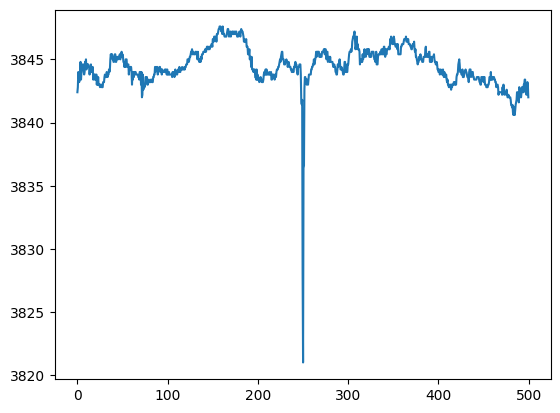

In [3]:
plt.plot(obs_grid, obs)

In [85]:
def compute_means(seed=0):
    np.random.seed(seed)

    data = pd.read_csv("../../../data/kaggle_HFT_index_futures.csv")
    true_obs = data["last_price"].to_numpy()[:1000]
    obs = true_obs.copy()
    obs_grid = (np.arange(0, len(obs)) * 0.001 * 500)[:1000]

    center_idx = 500
    outliers_idx = [center_idx + i for i in range(-4, 5, 1)]

    for i, drop in zip(outliers_idx, [0.9995, 0.9994, 0.9992, 0.996, 0.994, 0.998, 0.998, 0.9998]):
        drop += np.random.normal(0, 0.0001)
        obs[i] = obs[i]*drop

    """data = pd.read_csv("../../../data/kaggle_HFT_index_futures.csv")
    true_obs = data["last_price"].to_numpy()[:1000]
    obs = true_obs.copy()
    obs_grid = (np.arange(0, len(obs)) * 0.001 * 500)[:1000]

    center_idx = 500
    outliers_idx = [center_idx + i for i in range(-4, 5, 1)]

    for i, drop in zip(outliers_idx, [0.9995, 0.9994, 0.9992, 0.996, 0.994, 0.998, 0.998, 0.9998]):
        obs[i] = obs[i]*drop"""
    

    mean = obs.mean()
    obs_std = obs.std()
    obs = (obs- mean)/obs_std
    true_obs = (true_obs - mean)/obs_std

    m_rtgp, P_rtgp = rtgp(obs_grid, obs)
    m_std_gp, P_std_gp = stgp(obs_grid, obs)
    mu_EP, std_EP, EP_model = bayes_newton_EP(obs_grid, obs)
    mu_VI, std_VI, VI_model = bayes_newton_variational(obs_grid, obs)
    mu_laplace, std_laplace, laplace_model = bayes_newton_laplace(obs_grid, obs)

    return (mu_laplace, std_laplace), (mu_VI, std_VI), (mu_EP, std_EP), (m_rtgp, P_rtgp), (m_std_gp, P_std_gp), obs_grid, true_obs

In [96]:
rmses = []
nlpds = []

for i in range(20):
    (mu_laplace, std_laplace), (mu_VI, std_VI), (mu_EP, std_EP), (m_rtgp, P_rtgp), (m_std_gp, P_std_gp), obs_grid, true_obs = compute_means(seed=i*10)
    rmses.append( [rmse(mu_VI, true_obs), rmse(m_rtgp.flatten(), true_obs), rmse(m_std_gp.flatten(), true_obs), rmse(mu_EP, true_obs), rmse(mu_laplace, true_obs)] )
    nlpds.append( [nlpd(true_obs, mu_VI, std_VI), nlpd(true_obs, m_rtgp.flatten(), P_rtgp.flatten()), nlpd(true_obs, m_std_gp.flatten(), P_std_gp.flatten()), nlpd(true_obs, mu_EP, std_EP), nlpd(true_obs, mu_laplace, std_laplace)] )


Prediction time :  0.2797400951385498
Prediction time :  0.18917298316955566
optimisation time: 5.51 secs
Negative Log Predictive Density: 
-0.5919227820313877
Prediction time (s) :  0.8833019733428955
Lengthscale :  4.7437299537890345
Kernel Variance :  0.4396321032766685
optimisation time: 9.69 secs
Negative Log Predictive Density: 
-0.5868980526045618
Prediction time (s) :  1.1219580173492432
Lengthscale :  4.762470260723768
Kernel Variance :  0.4425621961388998
optimisation time: 5.70 secs
Negative Log Predictive Density: 
-1.2566729406685913
Prediction time (s) :  0.9653091430664062
Lengthscale :  1.277031138055617
Kernel Variance :  2.7757175170464454
Prediction time :  0.200120210647583
Prediction time :  0.15641283988952637
optimisation time: 4.02 secs
Negative Log Predictive Density: 
-0.5806038990488748
Prediction time (s) :  0.7897050380706787
Lengthscale :  4.826440407717851
Kernel Variance :  0.40336397395851564
optimisation time: 3.82 secs
Negative Log Predictive Density:

In [97]:
#VI, RTGP, STGP, EP, Laplace
np.array(rmses).mean(axis=0), np.array(rmses).std(axis=0)

(array([0.15383026, 0.14554504, 0.53825744, 0.14741017, 0.37385368]),
 array([0.01019389, 0.0025478 , 0.00458081, 0.00838054, 0.56220348]))

In [111]:
#Corrected Laplace
a = np.array(rmses)[:, -1]
a[a < 0.7].mean(), a[a<0.7].std()

(0.1692464416624302, 0.010468593423810926)

In [112]:
np.array(nlpds).mean(axis=0), np.array(nlpds).std(axis=0)

(array([-0.53380964, -0.62182598, 13.90805752, -0.56638476, -0.22434673]),
 array([0.03957745, 0.00735175, 0.26020525, 0.03093066, 0.54655801]))

In [117]:
a = np.array(nlpds)[:, -1]
a[a < 0].mean(), a[a < 0].std()

[ 1.83399206 -0.42185472 -0.26842415 -0.61497291 -0.3387325  -0.38885605
  0.78739922 -0.28116485 -0.39315447 -0.26333168 -0.41759397 -0.50939073
 -0.52773563 -0.25135545 -0.38883308 -0.36390751 -0.36932571 -0.55039237
 -0.29680318 -0.462497  ]


(-0.39490699764224924, 0.10287266828941569)

In [ ]:
#Corrected Laplace
a = np.array(rmses)[:, -1]
a[a < 0.7].mean(), a[a<0.7].std()

Method | RMSE | MAE | NLPD
MVI 0.15458713348473552 0.09886595080596881 -0.5443314472635224
RTGP 0.14460438221466418 0.10061502116027424 -0.6251038715926034
STGP 0.5396579780042329 0.09887510116940372 13.986769408307369
MEP 0.14360397185102022 0.09744515488120001 -0.5803364471670064
MLGP 0.1700309274558536 0.0880376051171654 -0.3894796451262136


Text(0.5, 0, 'Time (500ms)')

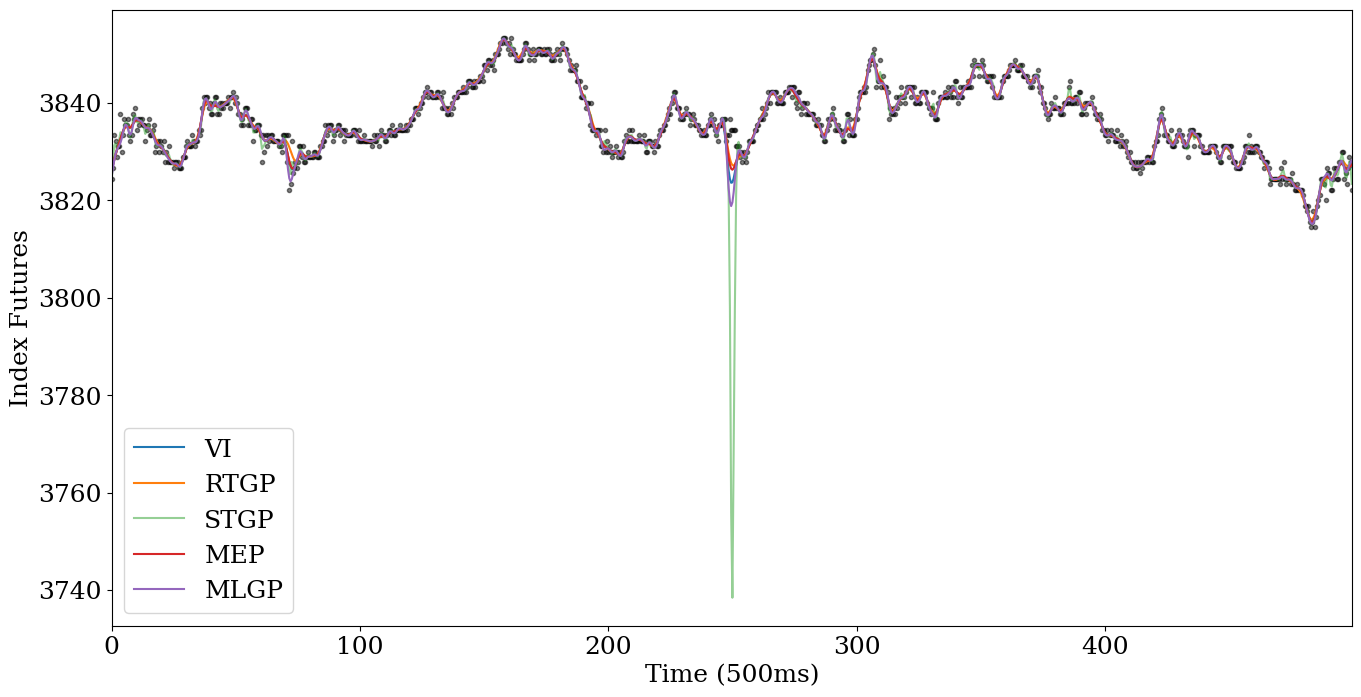

In [68]:
plt.rc('font', family='serif', size=18)

plt.figure(figsize=(16,8))
plt.plot(obs_grid, obs_std*true_obs + mean, '.', alpha=0.5, color='black')
plt.plot(obs_grid, obs_std*mu_VI + mean, label='VI')
plt.plot(obs_grid, obs_std*m_rtgp.flatten() + mean, label="RTGP")
plt.plot(obs_grid, obs_std*m_std_gp.flatten() + mean, alpha=0.5, label="STGP")
plt.plot(obs_grid, obs_std*mu_EP + mean, label="MEP")
plt.plot(obs_grid, obs_std*mu_laplace + mean, label="MLGP")
plt.xlim(obs_grid[0], obs_grid[-1])
plt.legend()

print("Method | RMSE | MAE | NLPD")
print("MVI", rmse(mu_VI, true_obs), mae(mu_VI, true_obs), nlpd(true_obs, mu_VI, std_VI))
print("RTGP", rmse(m_rtgp.flatten(), true_obs), mae(m_rtgp.flatten(), true_obs), nlpd(true_obs, m_rtgp.flatten(), P_rtgp.flatten()))
print("STGP", rmse(m_std_gp.flatten(), true_obs), mae(m_std_gp.flatten(), true_obs), nlpd(true_obs, m_std_gp.flatten(), P_std_gp.flatten()))
print("MEP", rmse(mu_EP, true_obs), mae(mu_EP, true_obs), nlpd(true_obs, mu_EP, std_EP))
print("MLGP", rmse(mu_laplace, true_obs), mae(mu_laplace, true_obs), nlpd(true_obs, mu_laplace, std_laplace))

plt.ylabel("Index Futures")
plt.xlabel("Time (500ms)")

#plt.savefig("./rmse-comparison-plot.pdf", format='pdf', bbox_inches='tight')